In [1]:
# Copyright 2022 Google LLC

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MULLER colab demo

This notebook shows how to use MULLER resizer in your project. More information can be found in this ICCV 2023 paper: [MULLER: Multilayer Laplacian Resizer for Vision](https://arxiv.org/abs/2304.02859)

In [ ]:
from typing import Tuple

import tensorflow as tf2

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#@title Define the model

class MullerResizer(tf2.keras.layers.Layer):
  """Learned Laplacian resizer in Keras Layer."""

  def __init__(
      self,
      target_size: Tuple[int, int] = (224, 224),
      base_resize_method: tf2.image.ResizeMethod = tf2.image.ResizeMethod.BILINEAR,
      antialias: bool = False,
      kernel_size: int = 5,
      stddev: float = 1.0,
      num_layers: int = 2,
      avg_pool: bool = False,
      dtype: tf2.DType = tf2.float32,
      init_weights: list = None,
      name: str = 'muller_resizer',
  ):
    """Applies a multilayer Laplacian filter on the input images.

    Args:
      target_size:  A tuple with target diemnsions (target_height,
        target_width).
      base_resize_method: Base image resizing method from
        tf2.image.ResizeMethod.
      antialias:  Whether to use antialias in resizer. Only tf2 resizer supports
        this feature.
      kernel_size: Size of the Gaussian filter.
      stddev: An optional float stddev, if provided will be directly used
        otherwise is determined using kernel_size.
      num_layers: Specifies the number of Laplacian layers.
      avg_pool: Whether to apply an average pooling before the base image
        resizer. The average pooling is only effective when input is downsized.
      dtype: Represents the data type used to cast input and the resizer
        weights. It should be consistent with the training / evaluation
        framework.
      init_weights: Wether to initialize the weights of the resizer.
      name: name scope of this layer.
    """
    super().__init__(name=name)

    self._target_size = target_size
    self._base_resize_method = base_resize_method
    self._antialias = antialias
    self._kernel_size = kernel_size
    self._stddev = stddev
    self._num_layers = num_layers
    self._avg_pool = avg_pool
    self._dtype = dtype
    self._init_weights = init_weights

  def build(self, input_shape: tf2.TensorShape) -> None:
    self._weights = []
    self._biases = []
    for layer in range(1, self._num_layers + 1):
      weight = self.add_weight(
          name='weight_' + str(layer),
          shape=[],
          dtype=self._dtype,
          initializer=tf2.keras.initializers.Constant(self._init_weights[2*layer-2])
          if self._init_weights else tf2.keras.initializers.zeros(),
      )
      bias = self.add_weight(
          name='bias_' + str(layer),
          shape=[],
          dtype=self._dtype,
          initializer=tf2.keras.initializers.Constant(self._init_weights[2*layer-1])
          if self._init_weights else tf2.keras.initializers.zeros(),
      )
      self._weights.append(weight)
      self._biases.append(bias)

    super().build(input_shape)

  def _base_resizer(self, inputs: tf2.Tensor) -> tf2.Tensor:
    """Base resizer function for muller."""
    stride = [
        1,
        inputs.get_shape().as_list()[1] // self._target_size[0],
        inputs.get_shape().as_list()[2] // self._target_size[1],
        1
    ]
    if self._avg_pool and stride[1] > 1 and stride[2] > 1:
      pooling_shape = [1, stride[1], stride[2], 1]
      inputs = tf2.nn.avg_pool(inputs, pooling_shape, stride, padding='SAME')

    return tf2.cast(
        tf2.image.resize(
            inputs,
            self._target_size,
            method=self._base_resize_method,
            antialias=self._antialias),
        self._dtype)

  def _gaussian_blur(self, inputs: tf2.Tensor) -> tf2.Tensor:
    """Gaussian blur function for muller."""
    stddev = tf2.cast(self._stddev, self._dtype)
    size = self._kernel_size
    radius = size // 2
    x = tf2.cast(tf2.range(-radius, radius + 1), self._dtype)
    blur_filter = tf2.exp(-tf2.pow(x, 2.0) / (2.0 * tf2.pow(stddev, 2.0)))
    blur_filter /= tf2.reduce_sum(blur_filter)
    # cast to dtype
    blur_v = tf2.reshape(blur_filter, [size, 1, 1, 1])
    blur_h = tf2.reshape(blur_filter, [1, size, 1, 1])
    num_channels = inputs.get_shape()[-1]
    blur_h = tf2.tile(blur_h, [1, 1, num_channels, 1])
    blur_v = tf2.tile(blur_v, [1, 1, num_channels, 1])
    blurred = tf2.nn.depthwise_conv2d(
        inputs, blur_h, strides=[1, 1, 1, 1], padding='SAME')
    blurred = tf2.nn.depthwise_conv2d(
        blurred, blur_v, strides=[1, 1, 1, 1], padding='SAME')
    return blurred

  def call(
      self,
      inputs: tf2.Tensor,
  ) -> tf2.Tensor:
    inputs.get_shape().assert_has_rank(4)

    if inputs.dtype != self._dtype:
      inputs = tf2.cast(inputs, self._dtype)

    # Creates the base resized image.
    net = self._base_resizer(inputs)

    # Multi Laplacian resizer.
    for weight, bias in zip(self._weights, self._biases):
      # Gaussian blur.
      blurred = self._gaussian_blur(inputs)
      # Residual image
      residual_image = blurred - inputs
      # Resize residual image.
      resized_residual = self._base_resizer(residual_image)
      # Add the residual to the input image.
      net = net + tf2.nn.tanh(weight * resized_residual + bias)
      inputs = blurred
    return net


In [ ]:
#@title Define model configs

_CONFIGS = {
  "target_size": (224, 224),
  "base_resize_method": "bilinear",
  "antialias": False,
  "kernel_size": 5,
  "stddev": 1.0,
  "num_layers": 2,
  "avg_pool": False,
  "dtype": tf2.float32,
  "name": 'muller_resizer',
  "init_weights": [1.892, -0.014, -11.295, 0.003],  # pre-trained weights for ResNet-50
}

In [ ]:
#@title Run the model
file_path = "https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG" #@param {type:"string"}
image_file = 'panda.jpg'
!wget {file_path} -O {image_file}

# init model
model = MullerResizer(**_CONFIGS)



--2023-09-11 22:24:50--  https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116068 (113K) [image/jpeg]
Saving to: ‘panda.jpg’

panda.jpg           100%[===================>] 113.35K  --.-KB/s    in 0.03s   

2023-09-11 22:24:50 (3.44 MB/s) - ‘panda.jpg’ saved [116068/116068]



In [ ]:
def inference(image_path, model):
    image = Image.open(image_path).convert("RGB")
    image = np.asarray(image) / 255.
    image = tf2.expand_dims(image, axis=0)
    preds = model(image)
    preds = np.array(preds[0], np.float32)
    return np.array(np.clip(preds, 0.0, 1.0))

pred_image = inference(image_file, model)

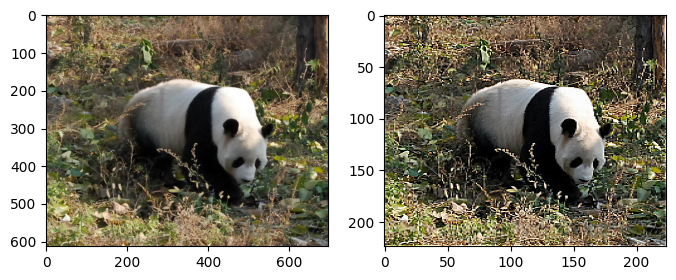

In [ ]:
#@title show images
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
input_image = np.asarray(Image.open(image_file).convert("RGB")) / 255.0
axes[0].imshow(input_image, aspect="auto")
axes[1].imshow(pred_image, aspect="auto")